In [156]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.select import Select
import pandas as pd
import time
from tqdm.notebook import tqdm
import googlemaps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import folium
import json

## 1. 사이트 분석

In [2]:
url = 'https://www.opinet.co.kr/user/main/mainView.do'
options = webdriver.ChromeOptions()
options.add_argument('--start-maximized')

driver = webdriver.Chrome('./driver/chromedriver.exe', options=options)
driver.get(url)

In [3]:
first_tag = driver.find_element(By.CSS_SELECTOR, '#header > div > ul > li:nth-child(1)')
second_tag = driver.find_element(By.CSS_SELECTOR, '#header > div > ul > li:nth-child(1) > ul > li:nth-child(1)')
action = ActionChains(driver)
action.move_to_element(first_tag).move_to_element(second_tag).click().perform()

In [4]:
sido_list_raw = driver.find_element(By.ID, 'SIDO_NM0')
sido_list = sido_list_raw.find_elements(By.TAG_NAME, 'option')
len(sido_list), sido_list[1].text

(18, '서울')

In [5]:
sido_names = []

for option in sido_list:
    sido_names.append(option.get_attribute('value'))

sido_names

['',
 '서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원특별자치도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [6]:
sido_names = [option.get_attribute('value') for option in sido_list]
sido_names = sido_names[1:]
sido_names

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원특별자치도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [7]:
sido_list_raw.send_keys(sido_names[0])

In [8]:
gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
gu_list = gu_list_raw.find_elements(By.TAG_NAME, 'option')
gu_list = gu_list[1:]
gu_names = [option.get_attribute('value') for option in gu_list]
gu_names, len(gu_names)

(['강남구',
  '강동구',
  '강북구',
  '강서구',
  '관악구',
  '광진구',
  '구로구',
  '금천구',
  '노원구',
  '도봉구',
  '동대문구',
  '동작구',
  '마포구',
  '서대문구',
  '서초구',
  '성동구',
  '성북구',
  '송파구',
  '양천구',
  '영등포구',
  '용산구',
  '은평구',
  '종로구',
  '중구',
  '중랑구'],
 25)

In [9]:
# 강남구 선택
gu_list_raw.send_keys(gu_names[0])    

In [10]:
# 옵션 클릭
option1 = driver.find_element(By.ID, 'CWSH_YN') # 세차장
option2 = driver.find_element(By.ID, 'MAINT_YN') # 경정비
option3 = driver.find_element(By.ID, 'CVS_YN') # 편의점
option4 = driver.find_element(By.ID, 'SEL24_YN') # 24시간
option1.click()
option2.click()
option3.click()
option4.click()


In [11]:
# '조회' 클릭
search_btn = driver.find_element(By.ID, 'searRgSelect')
search_btn.click()

In [20]:
# 주유소 목록
station_list = driver.find_element(By.ID, 'body1').find_elements(By.TAG_NAME, 'tr')
len(station_list)

31

In [13]:

driver.find_element(By.CSS_SELECTOR, '#body1 > tr:nth-child(2) > td.rlist > a').click()
html_tmp = driver.page_source
soup_tmp = BeautifulSoup(html_tmp, 'html.parser')
soup_tmp.find(id='os_nm').text # 주유소명

'(주)보성 세곡주유소'

In [14]:
print(soup_tmp.find(id='rd_addr').text) # 주소
print(soup_tmp.find(id='phn_no').text) # 전화번호
print(soup_tmp.find(id='poll_div_nm').text) # 브랜드
print(soup_tmp.find(id='b034_p').text if soup_tmp.find(id='b034_p').text != '' else '-') # 고급휘발유
print(soup_tmp.find(id='b027_p').text if soup_tmp.find(id='b027_p').text != '' else '-') # 보통휘발유
print(soup_tmp.find(id='d047_p').text if soup_tmp.find(id='d047_p').text != '' else '-') # 경유 
print(soup_tmp.find(id='c004_p').text if soup_tmp.find(id='c004_p').text != '' else '-') # 실내등유

print(soup_tmp.find(id='cwsh_yn').get('src')) # 세차장 이미지

서울 강남구  헌릉로 731 (세곡동)
02-445-6870
SK에너지
-
1,723
1,663
-
/images/user/gis/oil_station_service1_01.gif


In [15]:
# 부가정보 확인 테스트 함수
def check_status_simple(src):
    if '_off.gif' in src:
        print('N')
    else:
        print('Y')

In [16]:
check_status_simple(soup_tmp.find(id='cwsh_yn').get('src')) # 세차장
check_status_simple(soup_tmp.find(id='lpg_yn').get('src')) # 충전소
check_status_simple(soup_tmp.find(id='maint_yn').get('src')) # 경정비
check_status_simple(soup_tmp.find(id='cvs_yn').get('src')) # 편의점
check_status_simple(soup_tmp.find(id='sel24_yn').get('src')) # 24시영업

Y
N
N
N
N


In [17]:
# 부가정보 확인
def check_status(src):
    if '_off.gif' in src:
        return 'N'
    else:
        return 'Y'

In [18]:
print('Y' if soup_tmp.find(id='self_icon') is not None else 'N') # 셀프여부

Y


In [24]:
# 정보 추출

## 수집한 정보를 담을 빈 리스트
station_names = []
addr_list = []
brand_list = []
gas_list = []
diesel_list = []
self_list = []
wash_list = []
lpg_list = []
maint_list = []
cvs_list = []
sel24_list = []

# 주유소 목록에 따라 세부정보 확인 후 필요한 정보 스크래핑
for n in range(len(station_list)):
    WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, f'#body1 > tr:nth-child({n+1}) > td.rlist > a'))).click()
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    station_names.append(soup.find(id='os_nm').text) # 주유소명
    addr_list.append(soup.find(id='rd_addr').text) # 주소
    brand_list.append(soup.find(id='poll_div_nm').text) # 브랜드
    gas_list.append(soup.find(id='b027_p').text) # 휘발유
    diesel_list.append(soup.find(id='d047_p').text) # 경유
    self_list.append(
        'Y' if soup.find(id='self_icon') is not None else 'N') # 셀프여부
    wash_list.append(
        check_status(soup.find(id='cwsh_yn').get('src'))) # 세차장
    lpg_list.append(
        check_status(soup.find(id='lpg_yn').get('src'))) # 충전소
    maint_list.append(
        check_status(soup.find(id='maint_yn').get('src'))) # 경정비
    cvs_list.append(
        check_status(soup.find(id='cvs_yn').get('src'))) # 편의점
    sel24_list.append(
        check_status(soup.find(id='sel24_yn').get('src'))) # 24시 영업
    
    # 수집한 정보를 데이터 프레임으로 변환
    df = pd.DataFrame({
        '주유소명': station_names,
        '주소': addr_list,
        '브랜드': brand_list,
        '휘발유 가격': gas_list,
        '경유 가격': diesel_list,
        '셀프 여부': self_list,
        '세차장 여부': wash_list,
        '충전소 여부': lpg_list,
        '경정비 여부': maint_list,
        '편의점 여부': cvs_list,
        '24시간 운영 여부': sel24_list
    })

driver.quit()

In [25]:
df

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,24시간 운영 여부
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,"1,719","1,705",Y,Y,N,N,N,N
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,723","1,663",Y,Y,N,N,N,N
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,727","1,659",Y,Y,N,N,N,N
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,738","1,678",Y,Y,N,N,N,N
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,"1,744","1,689",Y,Y,N,Y,N,N
5,(주)중앙에너비스 수서지점,서울 강남구 광평로 202 (수서동),SK에너지,"1,747","1,657",Y,Y,N,N,N,N
6,오일프러스 셀프,서울 강남구 남부순환로 2651 (도곡동),SK에너지,"1,754","1,694",Y,Y,N,Y,N,Y
7,HD현대오일뱅크㈜직영 유진주유소,서울 강남구 논현로 152 (도곡동),HD현대오일뱅크,"1,754","1,704",N,Y,N,Y,N,N
8,극동유화㈜ 개나리주유소,서울 강남구 언주로 423 (역삼동),S-OIL,"1,755","1,695",Y,Y,N,Y,N,Y
9,자곡셀프주유소,서울 강남구 밤고개로 120 (자곡동),SK에너지,"1,757","1,679",Y,Y,N,N,N,N


## 2. 함수 작성 - 웹스크래핑

In [59]:
def fetch_oil():
    url = 'https://www.opinet.co.kr/searRgSelect.do'
    options = webdriver.ChromeOptions()
    options.add_argument('--start-maximized')
    driver = webdriver.Chrome('./driver/chromedriver.exe', options=options)
    driver.get(url)

    # 서울시 선택
    sido_list_raw = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.ID, 'SIDO_NM0')))
    sido_list_raw.send_keys('서울특별시')

    # 부가항목 옵션 선택
    option1 = driver.find_element(By.ID, 'CWSH_YN') # 세차장
    option2 = driver.find_element(By.ID, 'MAINT_YN') # 경정비
    option3 = driver.find_element(By.ID, 'CVS_YN') # 편의점
    option4 = driver.find_element(By.ID, 'SEL24_YN') # 24시간
    option1.click()
    option2.click()
    option3.click()
    option4.click()

    time.sleep(1)

    # 서울시 구 목록 확인
    gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
    gu_list = gu_list_raw.find_elements(By.TAG_NAME, 'option')
    gu_list = gu_list[1:]
    gu_names = [name.get_attribute('value') for name in gu_list]
    
    result_pd = []

    # 구별 주유소 목록을 통해 주유소별 세부정보 수집
    for gu in tqdm(gu_names):
        gu_box = driver.find_element(By.ID, 'SIGUNGU_NM0')
        select = Select(gu_box) # Select()를 통해 구 목록 선택
        select.select_by_visible_text(gu)

        driver.implicitly_wait(10)
        station_list = driver.find_element(By.ID, f'body1').find_elements(By.TAG_NAME, 'tr') # 구별 주유소 목록

        # 주유소 세부 정보를 담을 빈 리스트 
        station_names = []
        addr_list = []
        brand_list = []
        gas_list = []
        diesel_list = []
        self_list = []
        wash_list = []
        lpg_list = []
        maint_list = []
        cvs_list = []
        sel24_list = []

        # 주유소별 정부 추출
        for n in range(len(station_list)):
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.ID, f'body1')))
            driver.find_element(
                By.CSS_SELECTOR, 
                f'#body1 > tr:nth-child({n+1}) > td.rlist > a').click()
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            station_names.append(soup.find(id='os_nm').text) # 주유소명
            addr_list.append(soup.find(id='rd_addr').text) # 주소
            brand_list.append(soup.find(id='poll_div_nm').text) # 브랜드
            gas_list.append(soup.find(id='b027_p').text) # 휘발유
            diesel_list.append(soup.find(id='d047_p').text) # 경유
            self_list.append(
                'Y' if soup.find(id='self_icon') is not None else 'N') # 셀프여부
            wash_list.append(
                check_status(soup.find(id='cwsh_yn').get('src'))) # 세차장
            lpg_list.append(
                check_status(soup.find(id='lpg_yn').get('src'))) # 충전소
            maint_list.append(
                check_status(soup.find(id='maint_yn').get('src'))) # 경정비
            cvs_list.append(
                check_status(soup.find(id='cvs_yn').get('src'))) # 편의점
            sel24_list.append(
                check_status(soup.find(id='sel24_yn').get('src'))) # 24시 영업
            
            # 구별로 수집한 정보를 데이터 프레임으로 변환
            df = pd.DataFrame({
                '주유소명': station_names,
                '주소': addr_list,
                '브랜드': brand_list,
                '휘발유 가격': gas_list,
                '경유 가격': diesel_list,
                '셀프 여부': self_list,
                '세차장 여부': wash_list,
                '충전소 여부': lpg_list,
                '경정비 여부': maint_list,
                '편의점 여부': cvs_list,
                '24시간 운영 여부': sel24_list
            })
        
        result_pd.append(df) # 구별로 얻은 데이터 프레임을 추후 작업을 위해 리스트에 담아 둠
        print(len(df), gu) # 진행도를 알기 위해 구별 주유소 개수와 구 이름 출력
    result = pd.concat(result_pd, ignore_index=True) # 전체 데이터 프레임 통합
    driver.quit()
    return result

In [60]:
df_oil = fetch_oil()
df_oil

  0%|          | 0/25 [00:00<?, ?it/s]

31 강남구
12 강동구
10 강북구
26 강서구
10 관악구
10 광진구
16 구로구
8 금천구
13 노원구
14 도봉구
14 동대문구
7 동작구
8 마포구
13 서대문구
24 서초구
11 성동구
16 성북구
27 송파구
20 양천구
23 영등포구
11 용산구
12 은평구
5 종로구
7 중구
11 중랑구


,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,24시간 운영 여부
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,"1,719","1,705",Y,Y,N,N,N,N
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,723","1,663",Y,Y,N,N,N,N
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,727","1,659",Y,Y,N,N,N,N
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,738","1,678",Y,Y,N,N,N,N
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,"1,744","1,689",Y,Y,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...
354,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,"1,698","1,632",Y,Y,N,N,N,N
355,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,"1,698","1,638",N,Y,N,Y,N,N
356,우림주유소,서울 중랑구 용마산로 487 (망우제3동),GS칼텍스,"1,757","1,615",Y,Y,N,N,N,N
357,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,"1,758","1,688",Y,Y,N,N,N,N


In [62]:
ndf = df_oil.copy() # 작업간 실수를 대비해 원본 데이터프레임을 유지하고 복사본으로 작업을 진행

In [66]:
ndf['구'] = ndf['주소'].str.split().str[1]
ndf

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,24시간 운영 여부,구
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,"1,719","1,705",Y,Y,N,N,N,N,강남구
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,723","1,663",Y,Y,N,N,N,N,강남구
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,727","1,659",Y,Y,N,N,N,N,강남구
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,738","1,678",Y,Y,N,N,N,N,강남구
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,"1,744","1,689",Y,Y,N,Y,N,N,강남구
...,...,...,...,...,...,...,...,...,...,...,...,...
354,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,"1,698","1,632",Y,Y,N,N,N,N,중랑구
355,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,"1,698","1,638",N,Y,N,Y,N,N,중랑구
356,우림주유소,서울 중랑구 용마산로 487 (망우제3동),GS칼텍스,"1,757","1,615",Y,Y,N,N,N,N,중랑구
357,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,"1,758","1,688",Y,Y,N,N,N,N,중랑구


In [68]:
ndf['구'].unique(), len(ndf['구'].unique())

(array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
        '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
        '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object),
 25)

In [71]:
ndf.columns

Index(['주유소명', '주소', '브랜드', '휘발유 가격', '경유 가격', '셀프 여부', '세차장 여부', '충전소 여부',
       '경정비 여부', '편의점 여부', '24시간 운영 여부', '구'],
      dtype='object')

## 3. 구글맵을 활용한 위도/경도 정보 수집

In [72]:
def get_location(input_df):
    gmaps_key = 'API_Key'
    gmaps = googlemaps.Client(key=gmaps_key)

    input_list = input_df['주소']
    store_list = input_df['주유소명']

    result = input_df.copy()
    
    lat_list = []
    lng_list = []

    for idx, addr in tqdm(enumerate(input_list)):
        try:
            temp = gmaps.geocode(addr, language='ko')
            if temp:  # temp가 비어있지 않은지 확인
                lat = temp[0]['geometry']['location']['lat']
                lng = temp[0]['geometry']['location']['lng']
            else:
                print(f'{store_list[idx]} 지오코딩 결과가 존재하지 않습니다.')
                lat = 0  
                lng = 0
        except Exception as e:
            print(f"에러 발생 {store_list[idx]}: {e}")
            lat = 0  # 오류가 발생한 경우 위도에 0 할당
            lng = 0  # 오류가 발생한 경우 경도에 0 할당
        lat_list.append(lat)
        lng_list.append(lng)

    # 위도, 경도를 새로운 칼럼으로 추가
    result['lat'] = lat_list
    result['lng'] = lng_list

    return result

In [73]:
ndf_location = get_location(ndf)
ndf_location

0it [00:00, ?it/s]

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,24시간 운영 여부,구,lat,lng
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,"1,719","1,705",Y,Y,N,N,N,N,강남구,37.509858,127.065110
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,723","1,663",Y,Y,N,N,N,N,강남구,37.467157,127.118708
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,727","1,659",Y,Y,N,N,N,N,강남구,37.474993,127.106887
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,738","1,678",Y,Y,N,N,N,N,강남구,37.466567,127.119080
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,"1,744","1,689",Y,Y,N,Y,N,N,강남구,37.485462,127.043218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,"1,698","1,632",Y,Y,N,N,N,N,중랑구,37.617125,127.095896
355,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,"1,698","1,638",N,Y,N,Y,N,N,중랑구,37.609311,127.077673
356,우림주유소,서울 중랑구 용마산로 487 (망우제3동),GS칼텍스,"1,757","1,615",Y,Y,N,N,N,N,중랑구,37.592332,127.099105
357,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,"1,758","1,688",Y,Y,N,N,N,N,중랑구,37.579878,127.092182


In [74]:
ndf_location.info() # null값은 없음, 가격은 float로 변경, 컬럼제목 영문변경

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   주유소명        359 non-null    object 
 1   주소          359 non-null    object 
 2   브랜드         359 non-null    object 
 3   휘발유 가격      359 non-null    object 
 4   경유 가격       359 non-null    object 
 5   셀프 여부       359 non-null    object 
 6   세차장 여부      359 non-null    object 
 7   충전소 여부      359 non-null    object 
 8   경정비 여부      359 non-null    object 
 9   편의점 여부      359 non-null    object 
 10  24시간 운영 여부  359 non-null    object 
 11  구           359 non-null    object 
 12  lat         359 non-null    float64
 13  lng         359 non-null    float64
dtypes: float64(2), object(12)
memory usage: 39.4+ KB


In [76]:
ndf_location.describe() # 위경도에 이상치는 없어보임

,lat,lng
count,359.000000,359.000000
mean,37.544794,126.990044
std,0.052728,0.092273
min,37.441280,126.768428
25%,37.501637,126.908054
50%,37.538661,127.015328
75%,37.580350,127.061605
max,37.688431,127.172415


In [80]:
ndf_location['경유 가격'] = pd.to_numeric(ndf_location['경유 가격'].str.replace(',', ''), errors='coerce')
ndf_location['휘발유 가격'] = pd.to_numeric(ndf_location['휘발유 가격'].str.replace(',', ''), errors='coerce')
ndf_location

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,24시간 운영 여부,구,lat,lng
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,1719,1705.0,Y,Y,N,N,N,N,강남구,37.509858,127.065110
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1723,1663.0,Y,Y,N,N,N,N,강남구,37.467157,127.118708
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1727,1659.0,Y,Y,N,N,N,N,강남구,37.474993,127.106887
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1738,1678.0,Y,Y,N,N,N,N,강남구,37.466567,127.119080
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,1744,1689.0,Y,Y,N,Y,N,N,강남구,37.485462,127.043218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,1698,1632.0,Y,Y,N,N,N,N,중랑구,37.617125,127.095896
355,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,1698,1638.0,N,Y,N,Y,N,N,중랑구,37.609311,127.077673
356,우림주유소,서울 중랑구 용마산로 487 (망우제3동),GS칼텍스,1757,1615.0,Y,Y,N,N,N,N,중랑구,37.592332,127.099105
357,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,1758,1688.0,Y,Y,N,N,N,N,중랑구,37.579878,127.092182


In [81]:
ndf_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   주유소명        359 non-null    object 
 1   주소          359 non-null    object 
 2   브랜드         359 non-null    object 
 3   휘발유 가격      359 non-null    int64  
 4   경유 가격       358 non-null    float64
 5   셀프 여부       359 non-null    object 
 6   세차장 여부      359 non-null    object 
 7   충전소 여부      359 non-null    object 
 8   경정비 여부      359 non-null    object 
 9   편의점 여부      359 non-null    object 
 10  24시간 운영 여부  359 non-null    object 
 11  구           359 non-null    object 
 12  lat         359 non-null    float64
 13  lng         359 non-null    float64
dtypes: float64(3), int64(1), object(10)
memory usage: 39.4+ KB


In [83]:
ndf_location[ndf_location['경유 가격'].isna()] # 해당 주유소 확인 결과, 경유 가격이 없음. NaN 값은 추후 분석과정에 채우도록 함

,주유소명,주소,브랜드,휘발유 가격,경유 가격,셀프 여부,세차장 여부,충전소 여부,경정비 여부,편의점 여부,24시간 운영 여부,구,lat,lng
241,HD현대오일뱅크㈜직영 아리랑주유소,서울 성북구 아리랑로 96 (정릉동),HD현대오일뱅크,1737,NaN,N,Y,N,N,N,N,성북구,37.600488,127.014266


In [88]:
ndf_location.rename(columns={
    '주유소명': 'station_name',
    '주소' : 'addr',
    '브랜드': 'brand',
    '휘발유 가격': 'gasoline_price',
    '경유 가격': 'diesel_price',
    '셀프 여부': 'self_service',
    '세차장 여부': 'car_wash',
    '충전소 여부': 'lpg_charging',
    '경정비 여부': 'maint_service',
    '편의점 여부': 'conv_service',
    '24시간 운영 여부': '24_hour',
    '구': 'dist'
}, inplace=True)
ndf_location

,station_name,addr,brand,gasoline_price,diesel_price,self_service,car_wash,lpg_charging,maint_service,conv_service,24_hour,dist,lat,lng
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,1719,1705.0,Y,Y,N,N,N,N,강남구,37.509858,127.065110
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1723,1663.0,Y,Y,N,N,N,N,강남구,37.467157,127.118708
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1727,1659.0,Y,Y,N,N,N,N,강남구,37.474993,127.106887
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1738,1678.0,Y,Y,N,N,N,N,강남구,37.466567,127.119080
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,1744,1689.0,Y,Y,N,Y,N,N,강남구,37.485462,127.043218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,신내주유소,서울 중랑구 용마산로 705 (신내동),SK에너지,1698,1632.0,Y,Y,N,N,N,N,중랑구,37.617125,127.095896
355,범아주유소,서울 중랑구 동일로 881 (묵동),S-OIL,1698,1638.0,N,Y,N,Y,N,N,중랑구,37.609311,127.077673
356,우림주유소,서울 중랑구 용마산로 487 (망우제3동),GS칼텍스,1757,1615.0,Y,Y,N,N,N,N,중랑구,37.592332,127.099105
357,용마로주유소,서울 중랑구 용마산로 309 (면목동),SK에너지,1758,1688.0,Y,Y,N,N,N,N,중랑구,37.579878,127.092182


In [90]:
ndf_location.to_csv('./data/eda2_oil_price.csv', sep=',', encoding='utf-8', index=False)

## 4. 셀프 주유소가 정말 저렴한가

In [92]:
ndf_oil = pd.read_csv('./data/eda2_oil_price.csv')
ndf_oil.head()

,station_name,addr,brand,gasoline_price,diesel_price,self_service,car_wash,lpg_charging,maint_service,conv_service,24_hour,dist,lat,lng
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,1719,1705.0,Y,Y,N,N,N,N,강남구,37.509858,127.065110
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1723,1663.0,Y,Y,N,N,N,N,강남구,37.467157,127.118708
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1727,1659.0,Y,Y,N,N,N,N,강남구,37.474993,127.106887
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1738,1678.0,Y,Y,N,N,N,N,강남구,37.466567,127.119080
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,1744,1689.0,Y,Y,N,Y,N,N,강남구,37.485462,127.043218


In [93]:
ndf_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_name    359 non-null    object 
 1   addr            359 non-null    object 
 2   brand           359 non-null    object 
 3   gasoline_price  359 non-null    int64  
 4   diesel_price    358 non-null    float64
 5   self_service    359 non-null    object 
 6   car_wash        359 non-null    object 
 7   lpg_charging    359 non-null    object 
 8   maint_service   359 non-null    object 
 9   conv_service    359 non-null    object 
 10  24_hour         359 non-null    object 
 11  dist            359 non-null    object 
 12  lat             359 non-null    float64
 13  lng             359 non-null    float64
dtypes: float64(3), int64(1), object(10)
memory usage: 39.4+ KB


### (1) NaN값 채우기 
- 데이터의 왜곡을 줄이기 위해 NaN값은 해당구의 평균 경유가격으로 채움

In [97]:
ndf_oil[ndf_oil['diesel_price'].isna()]

,station_name,addr,brand,gasoline_price,diesel_price,self_service,car_wash,lpg_charging,maint_service,conv_service,24_hour,dist,lat,lng
241,HD현대오일뱅크㈜직영 아리랑주유소,서울 성북구 아리랑로 96 (정릉동),HD현대오일뱅크,1737,NaN,N,Y,N,N,N,N,성북구,37.600488,127.014266


In [100]:
mask = (ndf_oil['diesel_price'].notna()) & (ndf_oil['dist'] == '성북구')
ndf_oil[mask]['diesel_price'].mean()

1608.2

In [104]:
ndf_oil.loc[ndf_oil['station_name']=='HD현대오일뱅크㈜직영 아리랑주유소', 'diesel_price'] = 1608.2
ndf_oil.loc[ndf_oil['station_name']=='HD현대오일뱅크㈜직영 아리랑주유소']

,station_name,addr,brand,gasoline_price,diesel_price,self_service,car_wash,lpg_charging,maint_service,conv_service,24_hour,dist,lat,lng
241,HD현대오일뱅크㈜직영 아리랑주유소,서울 성북구 아리랑로 96 (정릉동),HD현대오일뱅크,1737,1608.2,N,Y,N,N,N,N,성북구,37.600488,127.014266


### (2) 구별 가격 확인 - 셀프서비스 여부에 따라

In [106]:
ndf_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_name    359 non-null    object 
 1   addr            359 non-null    object 
 2   brand           359 non-null    object 
 3   gasoline_price  359 non-null    int64  
 4   diesel_price    359 non-null    float64
 5   self_service    359 non-null    object 
 6   car_wash        359 non-null    object 
 7   lpg_charging    359 non-null    object 
 8   maint_service   359 non-null    object 
 9   conv_service    359 non-null    object 
 10  24_hour         359 non-null    object 
 11  dist            359 non-null    object 
 12  lat             359 non-null    float64
 13  lng             359 non-null    float64
dtypes: float64(3), int64(1), object(10)
memory usage: 39.4+ KB


In [117]:
self_df = pd.pivot_table(data=ndf_oil, index='dist', columns='self_service', values=['gasoline_price', 'diesel_price'], aggfunc=np.mean)
self_df

diesel_price              gasoline_price             
self_service            N            Y              N            Y
dist                                                              
강남구           2077.928571  1759.176471    2158.214286  1816.588235
강동구           1839.000000  1710.250000    1923.500000  1790.250000
강북구           1599.000000  1599.333333    1699.000000  1662.333333
강서구           1717.444444  1636.470588    1786.444444  1686.647059
관악구           1691.000000  1630.000000    1756.000000  1706.750000
광진구           1646.000000  1613.875000    1721.000000  1685.625000
구로구           1673.571429  1617.888889    1751.857143  1661.555556
금천구           1646.000000  1633.600000    1697.333333  1674.600000
노원구           1695.750000  1612.444444    1759.750000  1685.222222
도봉구           1677.000000  1586.230769    1747.000000  1658.000000
동대문구          1637.000000  1617.900000    1704.500000  1679.100000
동작구           1724.000000  1697.333333    1769.000000  1746.500000
마포구           1725.000000  1682.000000    1783.750000  1729.500000
서대문구          1661.666667  1646.000000    1731.666667  1699.500000
서초구           1761.571429  1686.900000    1820.714286  1736.400000
성동구           1867.333333  1662.200000    1915.666667  1722.200000
성북구           1608.200000  1608.200000    1737.000000  1676.933333
송파구           1706.375000  1667.631579    1778.000000  1726.263158
양천구           1645.400000  1626.466667    1702.800000  1674.733333
영등포구          1893.375000  1604.200000    1935.125000  1651.266667
용산구           2118.090909          NaN    2197.818182          NaN
은평구           1621.000000  1636.700000    1701.000000  1677.400000
종로구           1969.000000  1797.000000    2025.666667  1836.500000
중구            2160.800000  1617.000000    2208.600000  1697.000000
중랑구           1638.000000  1610.500000    1698.000000  1687.400000

In [118]:
ndf_oil[ndf_oil['dist'] == '용산구'] # 용산구는 셀프주유소가 없음

,station_name,addr,brand,gasoline_price,diesel_price,self_service,car_wash,lpg_charging,maint_service,conv_service,24_hour,dist,lat,lng
313,HD현대오일뱅크㈜직영 한남동주유소,서울 용산구 한남대로 204 (한남동),HD현대오일뱅크,1899,1859.0,N,Y,N,Y,N,N,용산구,37.545969,127.002875
314,(주)신태성주유소,서울 용산구 원효로 147 (원효로3가),SK에너지,2115,2059.0,N,Y,N,N,N,N,용산구,37.533727,126.956128
315,동자동주유소,서울 용산구 한강대로104길 6 (동자동),SK에너지,2150,2002.0,N,Y,N,N,N,N,용산구,37.552794,126.974797
316,HD현대오일뱅크㈜직영 갈월동주유소,서울특별시 용산구 한강대로 322 (남영동),HD현대오일뱅크,2150,2002.0,N,Y,N,Y,N,N,용산구,37.547038,126.972236
317,(주)영원 풍기주유소,서울 용산구 원효로 178 (원효로2가),GS칼텍스,2150,2040.0,N,N,N,N,Y,N,용산구,37.535617,126.962700
318,HD현대오일뱅크(주)직영 소월길주유소,서울 용산구 소월로 66 (후암동),HD현대오일뱅크,2154,2011.0,N,Y,N,N,N,N,용산구,37.550584,126.976996
319,HD현대오일뱅크㈜직영 강변현대주유소,서울 용산구 원효로 9 (청암동),HD현대오일뱅크,2154,2081.0,N,Y,N,Y,N,N,용산구,37.534496,126.946663
320,(주)남경주유소,서울 용산구 녹사평대로11길 24,SK에너지,2199,2146.0,N,Y,N,Y,N,Y,용산구,37.522633,126.993127
321,한석주유소,서울 용산구 이촌로 164,SK에너지,2259,2159.0,N,Y,N,N,N,Y,용산구,37.521390,126.965557
322,에너비스,서울 용산구 한남대로 82 (한남동),SK에너지,2297,2197.0,N,Y,N,N,N,N,용산구,37.536041,127.006128


In [120]:
self_df.columns = self_df.columns.get_level_values(0) + self_df.columns.get_level_values(1)
self_df

,diesel_priceN,diesel_priceY,gasoline_priceN,gasoline_priceY
dist,,,,
강남구,2077.928571,1759.176471,2158.214286,1816.588235
강동구,1839.000000,1710.250000,1923.500000,1790.250000
강북구,1599.000000,1599.333333,1699.000000,1662.333333
강서구,1717.444444,1636.470588,1786.444444,1686.647059
관악구,1691.000000,1630.000000,1756.000000,1706.750000
광진구,1646.000000,1613.875000,1721.000000,1685.625000
구로구,1673.571429,1617.888889,1751.857143,1661.555556
금천구,1646.000000,1633.600000,1697.333333,1674.600000
노원구,1695.750000,1612.444444,1759.750000,1685.222222


In [121]:
self_df['경유 가격차이'] = self_df['diesel_priceN'] - self_df['diesel_priceY']
self_df['휘발유 가격차이'] = self_df['gasoline_priceN'] - self_df['gasoline_priceY']
self_df = self_df[['diesel_priceN', 'diesel_priceY', '경유 가격차이', 'gasoline_priceN', 'gasoline_priceY', '휘발유 가격차이']]
self_df

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,
강남구,2077.928571,1759.176471,318.752101,2158.214286,1816.588235,341.626050
강동구,1839.000000,1710.250000,128.750000,1923.500000,1790.250000,133.250000
강북구,1599.000000,1599.333333,-0.333333,1699.000000,1662.333333,36.666667
강서구,1717.444444,1636.470588,80.973856,1786.444444,1686.647059,99.797386
관악구,1691.000000,1630.000000,61.000000,1756.000000,1706.750000,49.250000
광진구,1646.000000,1613.875000,32.125000,1721.000000,1685.625000,35.375000
구로구,1673.571429,1617.888889,55.682540,1751.857143,1661.555556,90.301587
금천구,1646.000000,1633.600000,12.400000,1697.333333,1674.600000,22.733333
노원구,1695.750000,1612.444444,83.305556,1759.750000,1685.222222,74.527778


In [122]:
self_df.describe()

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
count,25.000000,24.000000,24.000000,25.000000,24.000000,24.000000
mean,1759.980271,1648.304211,96.754783,1828.376267,1707.011162,105.971691
std,164.155735,51.784987,129.524141,160.288066,49.054638,121.149341
min,1599.000000,1586.230769,-15.700000,1697.333333,1651.266667,10.600000
25%,1646.000000,1613.517361,19.058333,1721.000000,1676.383333,31.141667
50%,1695.750000,1631.800000,49.341270,1759.750000,1687.023529,57.158333
75%,1839.000000,1671.223684,100.264423,1915.666667,1727.072368,108.160539
max,2160.800000,1797.000000,543.800000,2208.600000,1836.500000,511.600000


- 셀프 주유소는 평균적으로 경유가 96원 저렴함
- 셀프 주유소는 평균적으로 휘발유가 105원 저렴함
- 하지만 std가 100원 이상으로 구별 차이가 큼

In [126]:
# 셀프주유소의 경유가 50원 이상 싼 구
self_df[self_df['경유 가격차이'] > 50].sort_values(by='경유 가격차이', ascending=False)

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,
중구,2160.800000,1617.000000,543.800000,2208.600000,1697.000000,511.600000
강남구,2077.928571,1759.176471,318.752101,2158.214286,1816.588235,341.626050
영등포구,1893.375000,1604.200000,289.175000,1935.125000,1651.266667,283.858333
성동구,1867.333333,1662.200000,205.133333,1915.666667,1722.200000,193.466667
종로구,1969.000000,1797.000000,172.000000,2025.666667,1836.500000,189.166667
강동구,1839.000000,1710.250000,128.750000,1923.500000,1790.250000,133.250000
도봉구,1677.000000,1586.230769,90.769231,1747.000000,1658.000000,89.000000
노원구,1695.750000,1612.444444,83.305556,1759.750000,1685.222222,74.527778
강서구,1717.444444,1636.470588,80.973856,1786.444444,1686.647059,99.797386


- 구에 따라 셀프주유소 여부에 따라 가격차이 정도가 상이함
- 중구는 셀프주유소의 평균 경유가격이 500원 이상 저렴함
- 셀프주유소의 평균 경유가격이 100원 이상 차이를 보이는 지역은 중구, 강남구, 영등포구, 성동구, 종로구, 강동구 6개임

In [127]:
# 셀프주유소의 휘발유가 50원 이상 싼 구
self_df[self_df['휘발유 가격차이'] > 50].sort_values(by='휘발유 가격차이', ascending=False)

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,
중구,2160.800000,1617.000000,543.800000,2208.600000,1697.000000,511.600000
강남구,2077.928571,1759.176471,318.752101,2158.214286,1816.588235,341.626050
영등포구,1893.375000,1604.200000,289.175000,1935.125000,1651.266667,283.858333
성동구,1867.333333,1662.200000,205.133333,1915.666667,1722.200000,193.466667
종로구,1969.000000,1797.000000,172.000000,2025.666667,1836.500000,189.166667
강동구,1839.000000,1710.250000,128.750000,1923.500000,1790.250000,133.250000
강서구,1717.444444,1636.470588,80.973856,1786.444444,1686.647059,99.797386
구로구,1673.571429,1617.888889,55.682540,1751.857143,1661.555556,90.301587
도봉구,1677.000000,1586.230769,90.769231,1747.000000,1658.000000,89.000000


- 경유가격과 비슷하게 중구, 강남구, 영등포구, 성동구, 종로구, 강동구 6개구는 셀프주유소가 100원 이상 휘발유 가격이 저렴함
- 구에 따라 셀프주유소 여부에 따라 가격차이 정도가 상이함
- 중구는 셀프주유소의 평균 휘발유가격이 500원 이상 저렴함

In [146]:
# 일반 주유소의 경유가격이 높은순으로 정렬
self_df.sort_values(by='diesel_priceN', ascending=False)

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,
중구,2160.800000,1617.000000,543.800000,2208.600000,1697.000000,511.600000
용산구,2118.090909,NaN,NaN,2197.818182,NaN,NaN
강남구,2077.928571,1759.176471,318.752101,2158.214286,1816.588235,341.626050
종로구,1969.000000,1797.000000,172.000000,2025.666667,1836.500000,189.166667
영등포구,1893.375000,1604.200000,289.175000,1935.125000,1651.266667,283.858333
성동구,1867.333333,1662.200000,205.133333,1915.666667,1722.200000,193.466667
강동구,1839.000000,1710.250000,128.750000,1923.500000,1790.250000,133.250000
서초구,1761.571429,1686.900000,74.671429,1820.714286,1736.400000,84.314286
마포구,1725.000000,1682.000000,43.000000,1783.750000,1729.500000,54.250000


- 셀프주유소의 경유가격이 100원 이상 저렴한 6개구는 'diesel_priceN'가 가장 비싼 7개구에 속함
- 대체로 일반 주유소의 경유가격이 저렴할수록 셀프 주유소의 경유가격도 저렴함 = > '경유 가격차이'도 작아짐

In [147]:
# 일반 주유소의 휘발유가격이 높은순으로 정렬
self_df.sort_values(by='gasoline_priceN', ascending=False)

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,
중구,2160.800000,1617.000000,543.800000,2208.600000,1697.000000,511.600000
용산구,2118.090909,NaN,NaN,2197.818182,NaN,NaN
강남구,2077.928571,1759.176471,318.752101,2158.214286,1816.588235,341.626050
종로구,1969.000000,1797.000000,172.000000,2025.666667,1836.500000,189.166667
영등포구,1893.375000,1604.200000,289.175000,1935.125000,1651.266667,283.858333
강동구,1839.000000,1710.250000,128.750000,1923.500000,1790.250000,133.250000
성동구,1867.333333,1662.200000,205.133333,1915.666667,1722.200000,193.466667
서초구,1761.571429,1686.900000,74.671429,1820.714286,1736.400000,84.314286
강서구,1717.444444,1636.470588,80.973856,1786.444444,1686.647059,99.797386


- 휘발유도 경유와 비슷한 현상이 보임
- 셀프주유소의 휘발유 가격이 100원 이상 저렴한 6개구는 'gasoline_priceN'가 가장 비싼 7개구에 속함
- 대체로 일반 주유소의 휘발유가격이 저렴할수록 셀프 주유소의 휘발유가격도 저렴함 = > '휘발유 가격차이'도 작아짐

In [128]:
self_df[self_df['경유 가격차이'] < 0].sort_values(by='경유 가격차이', ascending=False)

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,
강북구,1599.0,1599.333333,-0.333333,1699.0,1662.333333,36.666667
은평구,1621.0,1636.700000,-15.700000,1701.0,1677.400000,23.600000


In [129]:
self_df[self_df['휘발유 가격차이'] < 0].sort_values(by='휘발유 가격차이', ascending=False)

,diesel_priceN,diesel_priceY,경유 가격차이,gasoline_priceN,gasoline_priceY,휘발유 가격차이
dist,,,,,,


- 차이가 크진 않지만 셀프주유소가 경유가격이 더 비싼 지역도 존재함

---

=> 
- 평균적으로 셀프주유소가 휘발유와 경유 모두 더 저렴하다
- 하지만, 주유가격이 저렴한 지역일수록 셀프주유소의 가격 메리트가 크지 않다
- 중구, 강남구, 영등포구 등 셀프주유소가 저렴한 지역은 평균적으로 주유가격이 비싼 지역임
- 주유가격이 비싼 지역에선 셀프주유소를 적극적으로 이용하는 것이 소비자에게 유리함
- 주유가격이 저렴한 지역에선 셀프주유소를 찾아서 주유할 유인이 적음

---

* **번외**

    - 셀프주유소의 주유가격이 저렴한 건 부가서비스가 적어서 그런건 아닐까?

### (3) 셀프주유소는 부가서비스가 적을까

In [131]:
ndf_oil.columns

Index(['station_name', 'addr', 'brand', 'gasoline_price', 'diesel_price',
       'self_service', 'car_wash', 'lpg_charging', 'maint_service',
       'conv_service', '24_hour', 'dist', 'lat', 'lng'],
      dtype='object')

In [144]:
# 주유소별로 몇개의 부가서비스를 제공하는 카운트
ndf_oil['부가서비스 개수'] = ndf_oil[
    ['car_wash', 'lpg_charging', 'maint_service', 'conv_service', '24_hour']].apply(
        lambda x: (x == 'Y').sum(), axis=1)

ndf_oil.head()

,station_name,addr,brand,gasoline_price,diesel_price,self_service,car_wash,lpg_charging,maint_service,conv_service,24_hour,dist,lat,lng,부가서비스 개수
0,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),HD현대오일뱅크,1719,1705.0,Y,Y,N,N,N,N,강남구,37.509858,127.065110,1
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1723,1663.0,Y,Y,N,N,N,N,강남구,37.467157,127.118708,1
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1727,1659.0,Y,Y,N,N,N,N,강남구,37.474993,127.106887,1
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1738,1678.0,Y,Y,N,N,N,N,강남구,37.466567,127.119080,1
4,HD현대오일뱅크㈜직영 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),HD현대오일뱅크,1744,1689.0,Y,Y,N,Y,N,N,강남구,37.485462,127.043218,2


In [145]:
ndf_service = pd.pivot_table(data=ndf_oil, 
                             index='dist', 
                             columns='self_service', 
                             values='부가서비스 개수', 
                             aggfunc=np.mean)

ndf_service

self_service,N,Y
dist,,
강남구,1.571429,1.705882
강동구,2.000000,1.375000
강북구,2.000000,1.555556
강서구,1.777778,2.058824
관악구,1.833333,1.500000
광진구,1.500000,1.750000
구로구,1.285714,1.444444
금천구,1.333333,1.600000
노원구,1.000000,1.444444


- 셀프주유소 여부에 따라 부가서비스 개수가 유의미한 차이를 보이진 않는 것 같음

### (4) 시각화

In [152]:
# 한글 설정
rc('font', family='Malgun Gothic')
rcParams['axes.unicode_minus'] = False

In [153]:
# 구별 주유소 숫자
def draw_countplot():
    plt.figure(figsize=(10, 6))
    sns.countplot(data=ndf_oil, x='dist', hue='self_service', 
                  order=ndf_oil['dist'].value_counts().index, 
                  palette='Set1')
    plt.xticks(rotation=45)
    plt.xlabel('구', size=15)
    plt.ylabel('주유소 숫자', size=15)
    plt.title('서울시 구별 셀프 주유소 숫자', size=20)
    plt.show()

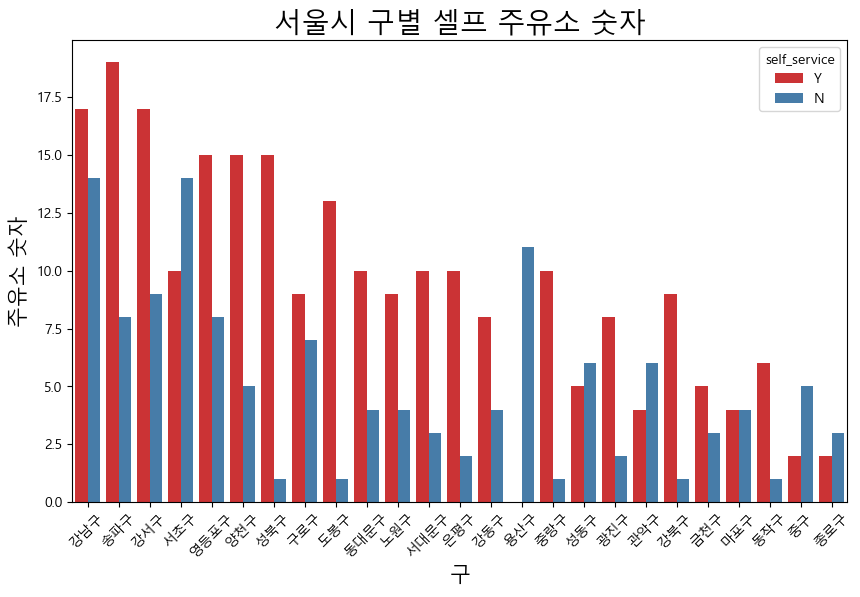

In [154]:
draw_countplot()

- 카운트 플랏에서도 용산구에는 셀프주유소가 없는 것을 확인할 수 있음
- 셀프주유소와 일반주유소의 숫자에 차이가 큰 지역들이 존재함

In [164]:
ndf_oil.columns

Index(['station_name', 'addr', 'brand', 'gasoline_price', 'diesel_price',
       'self_service', 'car_wash', 'lpg_charging', 'maint_service',
       'conv_service', '24_hour', 'dist', 'lat', 'lng', '부가서비스 개수'],
      dtype='object')

In [174]:

def draw_folium_Graph():
    geo_path = './data/02. skorea_municipalities_geo_simple.json'
    geo_str = json.load(open(geo_path, encoding='utf-8'))

    seoul = folium.Map(
        location=(37.5502, 126.982),
        zoom_start=11,
        tiles='cartodbpositron'
        )
    
    # 셀프 주유소와 일반 주유소의 경유가격차이를 지도에 시각화
    folium.Choropleth(
        geo_data=geo_str,
        data=self_df['경유 가격차이'],
        columns=[self_df.index, self_df['경유 가격차이']],
        key_on='feature.id',
        fill_color='RdPu',
        fill_opacity=0.4,
        line_opacity=0.4,
        legend_name='경유 가격차이'
    ).add_to(seoul)
    
    # 셀프주유소와 일반 주유소를 아이콘으로 구분하여 시각화
    for _, row in ndf_oil.iterrows():
        folium.Circle(
            location=(row['lat'], row['lng']),
            radius=100,
            popup= row['station_name'], 
            color= '#000099' if row['self_service'] == 'Y' else '#FF3333'
            ).add_to(seoul)

    return seoul

In [175]:
draw_folium_Graph() # 셀프주유소는 파란색, 일반주유소는 빨간색

- 용산구는 셀프주유소가 없어서 해당지역이 검은색으로 표시됨
- 서울시 외곽일수록 파란색점이 많이 보임 - > 셀프주유소가 많음

In [176]:
price_df = pd.pivot_table(data=ndf_oil, index='dist', values=['gasoline_price', 'diesel_price'], aggfunc=np.mean)
price_df

,diesel_price,gasoline_price
dist,,
강남구,1903.129032,1970.870968
강동구,1753.166667,1834.666667
강북구,1599.300000,1666.000000
강서구,1664.500000,1721.192308
관악구,1666.600000,1736.300000
광진구,1620.300000,1692.700000
구로구,1642.250000,1701.062500
금천구,1638.250000,1683.125000
노원구,1638.076923,1708.153846


In [177]:
# Choropleth로 시긱화하는 데이터를 구별 경유가격으로 변경
def draw_folium_diesel():
    geo_path = './data/02. skorea_municipalities_geo_simple.json'
    geo_str = json.load(open(geo_path, encoding='utf-8'))

    seoul = folium.Map(
        location=(37.5502, 126.982),
        zoom_start=11,
        tiles='cartodbpositron'
        )
    
    # 경유 가격에 따라 구별 색상을 시각화
    folium.Choropleth(
        geo_data=geo_str,
        data=price_df['diesel_price'],
        columns=[price_df.index, price_df['diesel_price']],
        key_on='feature.id',
        fill_color='YlOrBr',
        fill_opacity=0.4,
        line_opacity=0.4,
        legend_name='경유가격'
    ).add_to(seoul)
    
    # 셀프주유소와 일반 주유소를 아이콘으로 구분하여 시각화
    for _, row in ndf_oil.iterrows():
        folium.Circle(
            location=(row['lat'], row['lng']),
            radius=100,
            popup= row['station_name'], 
            color= '#000099' if row['self_service'] == 'Y' else '#FF3333'
            ).add_to(seoul)

    return seoul

In [179]:
draw_folium_diesel()

*  파란색 - 셀프 주유소, 빨간색 - 일반 주유소

- 경유 가격이 높은 서울 중심지일수록 빨간색 점에 비해 파란색이 점이 없음
- 경유 가격이 가장 높은 용산구는 셀프 주유소가 없음
- 위의 지도에서 확인했다시피 경유 가격이 저렴한 외곽지역일수록 파란색 점이 많음